A slightly class-ier version.  Hopefully this'll be the last 'generation' of notebook for this.  Anyone who's good at Python code reviews please follow along and give feedback :)

The plan is to document things *a lot* better as I go along and put things in a nice OO (and closer to PEP8) style.  (This generally hasn't been met yet)

-r3 is implementing PAL.

In [1]:
from base64 import b64encode
import copy
from datetime import datetime
import getopt
from io import BytesIO
import os
import sys

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(20, 12))

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

#internal libraries which may or may not get used
import fdls

Helper/graphing functions.  This will be broken out into it's own .py file once done.

In [2]:
# charting/graphing code carried over from earlier development efforts
# (will probably be moved back into a ldutils2 package)

def todb(y, zero = False):
    db = 20 * np.log10(np.abs(y))
    if zero:
        return db - np.max(db)
    else:
        return db

def plotfilter_wh(w, h, freq, zero_base = False):
    db = todb(h, zero_base)
    
    above_m3 = None
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i]) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i])
            above_m3 = i
        if (db[i] < -3) and (db[i - 1] >= -3):
            if above_m3 is not None:
                peak_index = np.argmax(db[above_m3:i]) + above_m3
                print("peak at ", w[peak_index], db[peak_index])
            print("<-3db crossing at ", w[i]) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i]) 
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, db, 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

def plotfilter(B, A, freq = 40, whole = False, zero_base = False):
    w, h = sps.freqz(B, A, whole = whole, worN=4096)
    
    if whole:
        w = np.arange(0, freq, freq / len(h))
    else:
        w = np.arange(0, (freq / 2), (freq / 2) / len(h))
        
    return plotfilter_wh(w, h, freq, zero_base)

# Draws a uint16 image, downscaled to uint8
def draw_raw_bwimage(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [3]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    
def downscale_field(data, lineinfo, outwidth=1820, lines=625, usewow=False):
    ilinepx = linelen
    dsout = np.zeros((len(lineinfo) * outwidth), dtype=np.double)    

    sfactor = [None]

    for l in range(1, 262):
        scaled = scale(data, lineinfo[l], lineinfo[l + 1], outwidth)
        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / outwidth)

        if usewow:
            wow = (lineinfo[l + 1] - lineinfo[l]) / linelen
            scaled *= wow
                
        dsout[l * outwidth:(l + 1)*outwidth] = scaled
        
    return dsout


For this part of the loader phase I found myself going to function objects that implement this sample API:

```
infile: standard readable/seekable python binary file
sample: starting sample #
readlen: # of samples
```
Returns data if successful, or None or an upstream exception if not (including if not enough data is available)

This might probably need to become a full object once FLAC support is added.

In [4]:

def load_unpacked_data(infile, sample, readlen, sampletype):
    # this is run for unpacked data - 1 is for old cxadc data, 2 for 16bit DD
    infile.seek(sample * sampletype, 0)
    inbuf = infile.read(readlen * sampletype)

    if sampletype == 2:
        indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
    else:
        indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
    return indata

def load_unpacked_data_u8(infile, sample, readlen):
    return load_unpacked_data(infile, sample, readlen, 1)

def load_unpacked_data_s16(infile, sample, readlen):
    return load_unpacked_data(infile, sample, readlen, 2)

# This is for the .r30 format I did in ddpack/unpack.c.  Depricated but I still have samples in it.
def load_packed_data_3_32(infile, sample, readlen):
    start = (sample // 3) * 4
    offset = sample % 3
    start, offset

    infile.seek(start)

    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 3 / 4) * 4) + 4

    inbuf = infile.read(needed)
    indata = np.fromstring(inbuf, 'uint32', len(inbuf) // 4)

    unpacked = np.zeros(len(indata) * 3, dtype=np.int16)

    # By using strides the unpacked data can be loaded with no additional copies
    np.bitwise_and(indata, 0x3ff, out = unpacked[0::3])
    # hold the shifted bits in it's own array to avoid an allocation
    tmp = np.right_shift(indata, 10)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[1::3])
    np.right_shift(indata, 20, out = tmp)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[2::3])

    return unpacked[offset:offset + readlen]


# The 10-bit samples from the Duplicator...

'''
From Simon's code:

// Original
// 0: xxxx xx00 0000 0000
// 1: xxxx xx11 1111 1111
// 2: xxxx xx22 2222 2222
// 3: xxxx xx33 3333 3333
//
// Packed:
// 0: 0000 0000 0011 1111
// 2: 1111 2222 2222 2233
// 4: 3333 3333
'''

# The bit twiddling is a bit more complex than I'd like... but eh.  I think
# it's debugged now. ;)
def load_packed_data_4_40(infile, sample, readlen):
    start = (sample // 4) * 5
    offset = sample % 4

    seekedto = infile.seek(start)
    
    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 5 // 4)) + 5

    inbuf = infile.read(needed)
    indata = np.frombuffer(inbuf, 'uint8', len(inbuf))

    rot2 = np.right_shift(indata, 2)

    unpacked = np.zeros(readlen + 4, dtype=np.uint16)

    # we need to load the 8-bit data into the 16-bit unpacked for left_shift to work
    # correctly...
    unpacked[0::4] = indata[0::5]
    np.left_shift(unpacked[0::4], 2, out=unpacked[0::4])
    np.bitwise_or(unpacked[0::4], np.bitwise_and(np.right_shift(indata[1::5], 6), 0x03), out=unpacked[0::4])

    unpacked[1::4] = np.bitwise_and(indata[1::5], 0x3f)
    np.left_shift(unpacked[1::4], 4, out=unpacked[1::4])
    np.bitwise_or(unpacked[1::4], np.bitwise_and(np.right_shift(indata[2::5], 4), 0x0f), out=unpacked[1::4])

    unpacked[2::4] = np.bitwise_and(indata[2::5], 0x0f)
    np.left_shift(unpacked[2::4], 6, out=unpacked[2::4])
    np.bitwise_or(unpacked[2::4], np.bitwise_and(np.right_shift(indata[3::5], 2), 0x3f), out=unpacked[2::4])

    unpacked[3::4] = np.bitwise_and(indata[3::5], 0x03)
    np.left_shift(unpacked[3::4], 8, out=unpacked[3::4])
    np.bitwise_or(unpacked[3::4], indata[4::5], out=unpacked[3::4])

    return unpacked[offset:offset + readlen]



In [5]:
# Essential standalone routines 

pi = np.pi
tau = np.pi * 2

#https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
polar2z = lambda r,θ: r * np.exp( 1j * θ )
deg2rad = lambda θ: θ * (np.pi / 180)

# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html

# hilbert_filter_terms has a direct impact on filter delays.  Emperical testing
# determined that 128 was a good value here.
hilbert_filter_terms = 128
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
#fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

# This converts a regular B, A filter to an FFT of our selected block length
def filtfft(filt, blocklen):
    return sps.freqz(filt[0], filt[1], blocklen, whole=1)[1]

In [6]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

In [7]:
def calczc(data, _start_offset, target, edge='both', reverse=False, _count=10):
    start_offset = int(_start_offset)
    count = int(_count + 1)
    
    if edge == 'both': # capture rising or falling edge
        if data[start_offset] < target:
            edge = 'rising'
        else:
            edge = 'falling'

    if edge == 'rising':
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
               
    if len(locs) == 0:
        return None

    if reverse:
        index = -1
    else:
        index = 0
        
    x = start_offset + locs[index] #+ offset
    
    if (x == 0):
        #print("BUG:  cannot figure out zero crossing for beginning of data")
        return None
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y

def calczc_sets(data, start, end, tgt = 0, cliplevel = None):
    zcsets = {False: [], True:[]}
    bi = star
    while bi < end:
        if np.abs(data[bi]) > cliplevel:
            zc = calczc(data, bi, tgt)

            if zc is not None:
                zcsets[data[bi] > tgt].append(offset)
                bi = np.int(zc)

        bi += 1
    
    return {False: np.array(zcsets[False]), True: np.array(zcsets[True])}

In [8]:
def unwrap_hilbert(hilbert, freq_hz):
    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    return (tdangles2 * (freq_hz / tau))

In [9]:
def calclinelen(SP, mult, mhz):
    if type(mhz) == str:
        mhz = SP[mhz]
        
    return int(np.round(SP['line_period'] * mhz * mult)) 

# These are invariant parameters 
SysParams_NTSC = {
    'fsc_mhz': (315.0 / 88.0),
    'pilot_mhz': (315.0 / 88.0),
    'frame_lines': 525,

    'ire0': 8100000,
    'hz_ire': 1700000 / 140.0,

    # most NTSC disks have analog audio, except CD-V and a few Panasonic demos
    'analog_audio': True,
    # From the spec - audio frequencies are multiples of the (color) line rate
    'audio_lfreq': (1000000*315/88/227.5) * 146.25,
    'audio_rfreq': (1000000*315/88/227.5) * 178.75,
    
    'philips_codelines': [16, 17, 18]
}

# In color NTSC, the line period was changed from 63.5 to 227.5 color cycles,
# which works out to 63.5(with a bar on top) usec
SysParams_NTSC['line_period'] = 1/(SysParams_NTSC['fsc_mhz']/227.5)
SysParams_NTSC['FPS'] = 1000000/ (525 * SysParams_NTSC['line_period'])

SysParams_NTSC['outlinelen'] = calclinelen(SysParams_NTSC, 4, 'fsc_mhz')

SysParams_PAL = {
    'FPS': 25,
    
    'fsc_mhz': ((1/64) * 283.75) + (25/1000000),
    'pilot_mhz': 3.75,
    'frame_lines': 625,
    'line_period': 64,

    'ire0': 7100000,
    'hz_ire': 800000 / 100.0,

    # only early PAL disks have analog audio
    'analog_audio': False,
    # From the spec - audio frequencies are multiples of the (color) line rate
    'audio_lfreq': (1000000/64) * 43.75,
    'audio_rfreq': (1000000/64) * 68.25,

    'philips_codelines': [19, 20, 21]
}

SysParams_PAL['outlinelen'] = calclinelen(SysParams_PAL, 4, 'fsc_mhz')
SysParams_PAL['outlinelen_pilot'] = calclinelen(SysParams_PAL, 4, 'pilot_mhz')


In [10]:
RFParams_NTSC = {
    # The audio notch filters are important with DD v3.0+ boards
    'audio_notchwidth': 350000,
    'audio_notchorder': 2,

    # (note:  i don't know how to handle these values perfectly yet!)
    'video_deemp': (120*.32, 320*.32), # On some captures this is as low as .55.

    # This BPF is similar but not *quite* identical to what Pioneer did
    'video_bpf': [3500000, 13200000],
    'video_bpf_order': 3,

    # This can easily be pushed up to 4.5mhz or even a bit higher. 
    # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
    'video_lpf_freq': 4200000,   # in mhz
    'video_lpf_order': 5 # butterworth filter order
}

RFParams_PAL = {
    # The audio notch filters are important with DD v3.0+ boards
    'audio_notchwidth': 200000,
    'audio_notchorder': 2,

    'video_deemp': (100*.32, 400*.32),

    # XXX: guessing here!
    'video_bpf': (2600000, 12500000),
    'video_bpf_order': 3,

    'video_lpf_freq': 4800000,
    'video_lpf_order': 5,
    
}

In [11]:
class RFDecode:
    def __init__(self, inputfreq = 40, system = 'NTSC', blocklen_ = 16384):
        self.blocklen = blocklen_
        self.blockcut = 1024 # ???
        self.system = system
        
        freq = inputfreq
        self.freq = freq
        self.freq_half = freq / 2
        self.freq_hz = self.freq * 1000000
        self.freq_hz_half = self.freq * 1000000 / 2
        
        if system == 'NTSC':
            self.SysParams = SysParams_NTSC
            self.DecoderParams = RFParams_NTSC
            
            self.Filters = {
                'MTF': sps.zpk2tf([], [polar2z(.7,np.pi*12.5/20), polar2z(.7,np.pi*27.5/20)], 1.11)
            }
        elif system == 'PAL':
            self.SysParams = SysParams_PAL
            self.DecoderParams = RFParams_PAL
            
            self.Filters = {
                'MTF': sps.zpk2tf([], [polar2z(.7,np.pi*10/20), polar2z(.7,np.pi*28/20)], 1.11)
            }

        linelen = self.freq_hz/(1000000.0/self.SysParams['line_period'])
        self.linelen = int(np.round(linelen))
            
        self.computevideofilters()
        if self.SysParams['analog_audio']: 
            self.computeaudiofilters()
            
    def computevideofilters(self):
        self.Filters = {}
        
        # Use some shorthand to compact the code.  good idea?  prolly not.
        SF = self.Filters
        SP = self.SysParams
        DP = self.DecoderParams
        
        SF['hilbert'] = np.fft.fft(hilbert_filter, self.blocklen)
        
        filt_rfvideo = sps.butter(DP['video_bpf_order'], [DP['video_bpf'][0]/self.freq_hz_half, DP['video_bpf'][1]/self.freq_hz_half], btype='bandpass')
        SF['RFVideo'] = filtfft(filt_rfvideo, self.blocklen)

        if SP['analog_audio']: 
            cut_left = sps.butter(DP['audio_notchorder'], [(SP['audio_lfreq'] - DP['audio_notchwidth'])/self.freq_hz_half, (SP['audio_lfreq'] + DP['audio_notchwidth'])/self.freq_hz_half], btype='bandstop')
            SF['Fcutl'] = filtfft(cut_left, self.blocklen)
            cut_right = sps.butter(DP['audio_notchorder'], [(SP['audio_rfreq'] - DP['audio_notchwidth'])/self.freq_hz_half, (SP['audio_rfreq'] + DP['audio_notchwidth'])/self.freq_hz_half], btype='bandstop')
            SF['Fcutr'] = filtfft(cut_right, self.blocklen)
        
            SF['RFVideo'] *= (SF['Fcutl'] * SF['Fcutr'])
            
        SF['RFVideo'] *= SF['hilbert']
        
        video_lpf = sps.butter(DP['video_lpf_order'], DP['video_lpf_freq']/self.freq_hz_half, 'low')
        SF['Fvideo_lpf'] = filtfft(video_lpf, self.blocklen)

        # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
        deemp0, deemp1 = DP['video_deemp']
        [tf_b, tf_a] = sps.zpk2tf(-deemp1*(10**-10), -deemp0*(10**-10), deemp0 / deemp1)
        SF['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/self.freq_hz_half), self.blocklen)

        # The direct opposite of the above, used in test signal generation
        [tf_b, tf_a] = sps.zpk2tf(-deemp0*(10**-10), -deemp1*(10**-10), deemp1 / deemp0)
        SF['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/self.freq_hz_half), self.blocklen)
        
        # Post processing:  lowpass filter + deemp
        SF['FVideo'] = SF['Fvideo_lpf'] * SF['Fdeemp'] 
    
        # additional filters:  0.5mhz and color burst
        # Using an FIR filter here to get tighter alignment
        F0_5 = sps.firwin(65, [0.5/self.freq_half], pass_zero=True)
        SF['F0_5'] = filtfft((F0_5, [1.0]), self.blocklen)
        SF['FVideo05'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['F0_5']

        SF['Fburst'] = filtfft(sps.butter(1, [(SP['fsc_mhz']-.1)/self.freq_half, (SP['fsc_mhz']+.1)/self.freq_half], btype='bandpass'), self.blocklen) 
        SF['FVideoBurst'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['Fburst']

        if self.system == 'PAL':
            SF['Fpilot'] = filtfft(sps.butter(1, [3.7/self.freq_half, 3.8/self.freq_half], btype='bandpass'), self.blocklen) 
            SF['FVideoPilot'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['Fpilot']
        
        # emperical work determined that a single-pole low frequency filter effectively 
        # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
        f = sps.butter(1, 0.05/self.freq_half, btype='low')
        SF['FPsync'] = filtfft(f, self.blocklen)

    # frequency domain slicers.  first and second stages use different ones...
    def audio_fdslice(self, freqdomain):
        return np.concatenate([freqdomain[self.Filters['audio_fdslice_lo']], freqdomain[self.Filters['audio_fdslice_hi']]])

    def audio_fdslice2(self, freqdomain):
        return np.concatenate([freqdomain[self.Filters['audio_fdslice2_lo']], freqdomain[self.Filters['audio_fdslice2_hi']]])
    
    def computeaudiofilters(self):
        SF = self.Filters
        SP = self.SysParams
        DP = self.DecoderParams

        # first stage audio filters
        if self.freq >= 32:
            audio_fdiv1 = 32 # this is good for 40mhz - 16 should be ideal for 28mhz
        else:
            audio_fdiv1 = 16
            
        SF['audio_fdiv1'] = audio_fdiv1
            
        afft_halfwidth = self.blocklen // (audio_fdiv1 * 2)
        arf_freq = self.freq_hz / (audio_fdiv1 / 2)
        SF['freq_arf'] = arf_freq
        SF['audio_fdiv1'] = audio_fdiv1

        SP['audio_cfreq'] = (SP['audio_rfreq'] + SP['audio_lfreq']) // 2
        afft_center = int((SP['audio_cfreq'] / self.freq_hz) * (self.blocklen))

        # beginning and end symmetrical frequency domain slices.  combine to make a cut-down sampling
        afft_start = int(afft_center-afft_halfwidth)
        afft_end = int(afft_center+afft_halfwidth)

        # slice areas for reduced FFT audio demodulation filters
        SF['audio_fdslice_lo'] = slice(afft_start, afft_end)
        SF['audio_fdslice_hi'] = slice(self.blocklen-afft_end, self.blocklen-afft_start)

        # compute the base frequency of the cut audio range
        SF['audio_lowfreq'] = SP['audio_cfreq']-(self.freq_hz/(2*SF['audio_fdiv1']))

        apass = 150000 # audio RF bandpass.  150khz is the maximum transient.
        afilt_len = 800 # good for 150khz apass

        afilt_left = filtfft([sps.firwin(afilt_len, [(SP['audio_lfreq']-apass)/self.freq_hz_half, (SP['audio_lfreq']+apass)/self.freq_hz_half], pass_zero=False), 1.0], self.blocklen)
        SF['audio_lfilt'] = self.audio_fdslice(afilt_left * SF['hilbert']) 
        afilt_right = filtfft([sps.firwin(afilt_len, [(SP['audio_rfreq']-apass)/self.freq_hz_half, (SP['audio_rfreq']+apass)/self.freq_hz_half], pass_zero=False), 1.0], self.blocklen)
        SF['audio_rfilt'] = self.audio_fdslice(afilt_right * SF['hilbert'])

        # second stage audio filters (decimates further, and applies audio LPF)
        audio_fdiv2 = 4
        SF['audio_fdiv2'] = audio_fdiv2
        SF['audio_fdiv'] = audio_fdiv1 * audio_fdiv2
        SF['freq_aud2'] = SF['freq_arf'] / audio_fdiv2

        # slice areas for reduced FFT audio filters
        SF['audio_fdslice2_lo'] = slice(0, self.blocklen//(audio_fdiv2*2))
        SF['audio_fdslice2_hi'] = slice(self.blocklen-self.blocklen//(audio_fdiv2*2), self.blocklen)

        SF['audio_lpf2'] = filtfft([sps.firwin(65, [21000/(SF['freq_aud2']/2)]), [1.0]], self.blocklen // SF['audio_fdiv2'])

        # convert 75usec into the exact -3dB frequency
        d75freq = 1000000/(2*pi*75)

        # I was overthinking deemphasis for a while.  For audio it turns out a straight
        # 1-pole butterworth does a good job.
        adeemp_b, adeemp_a = sps.butter(1, [d75freq/(SF['freq_aud2']/2)], btype='lowpass')
        SF['audio_deemp2'] = filtfft([adeemp_b, adeemp_a],  self.blocklen // SF['audio_fdiv2'])
        
        
    def iretohz(self, ire):
        return self.SysParams['ire0'] + (self.SysParams['hz_ire'] * ire)

    def hztoire(self, hz):
        return (hz - self.SysParams['ire0']) / self.SysParams['hz_ire']
    
    def demodblock(self, data, mtf_level = 0):
        indata_fft = np.fft.fft(data[:self.blocklen])
        indata_fft_filt = indata_fft * self.Filters['RFVideo']

        if mtf_level != 0:
            indata_fft_filt *= self.Filters['MTF'] ** mtf_level

        hilbert = np.fft.ifft(indata_fft_filt)
        demod = unwrap_hilbert(hilbert, self.freq_hz)

        demod_fft = np.fft.fft(demod)

        out_video = np.fft.ifft(demod_fft * self.Filters['FVideo']).real
        out_video05 = np.fft.ifft(demod_fft * self.Filters['FVideo05']).real
        out_videoburst = np.fft.ifft(demod_fft * self.Filters['FVideoBurst']).real
        
        # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
        output_sync = inrange(out_video05, self.iretohz(-55), self.iretohz(-25))
        # Perform FFT convolution of above filter
        output_syncf = np.fft.ifft(np.fft.fft(output_sync) * self.Filters['FPsync']).real

        if self.system == 'PAL':
            out_videopilot = np.fft.ifft(demod_fft * self.Filters['FVideoPilot']).real
            rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst, out_videopilot], names=['demod', 'demod_05', 'demod_sync', 'demod_burst', 'demod_pilot'])
        else:
            rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])

        if self.SysParams['analog_audio'] == False:
            return rv_video, None

        # Audio phase 1
        hilbert = np.fft.ifft(self.audio_fdslice(indata_fft) * self.Filters['audio_lfilt'])
        audio_left = unwrap_hilbert(hilbert, self.Filters['freq_arf']) + self.Filters['audio_lowfreq']

        hilbert = np.fft.ifft(self.audio_fdslice(indata_fft) * self.Filters['audio_rfilt'])
        audio_right = unwrap_hilbert(hilbert, self.Filters['freq_arf']) + self.Filters['audio_lowfreq']

        rv_audio = np.rec.array([audio_left, audio_right], names=['audio_left', 'audio_right'])

        return rv_video, rv_audio
    
    # Second phase audio filtering.  This works on a whole field's samples, since 
    # the frequency is reduced by 16/32x.

    def runfilter_audio_phase2(self, frame_audio, start):
        left = frame_audio['audio_left'][start:start+self.blocklen].copy() 
        left_fft = np.fft.fft(left)
        audio_out_fft = self.audio_fdslice2(left_fft) * self.Filters['audio_lpf2']
        left_out = np.fft.ifft(audio_out_fft).real / self.Filters['audio_fdiv2']

        right = frame_audio['audio_right'][start:start+self.blocklen].copy() 
        right_fft = np.fft.fft(right)
        audio_out_fft = self.audio_fdslice2(right_fft) * self.Filters['audio_lpf2'] #* adeemp
        right_out = np.fft.ifft(audio_out_fft).real / self.Filters['audio_fdiv2']

        return np.rec.array([left_out, right_out], names=['audio_left', 'audio_right'])

    def audio_phase2(self, field_audio):
        # this creates an output array with left/right channels.
        output_audio2 = np.zeros(len(field_audio['audio_left']) // self.Filters['audio_fdiv2'], dtype=field_audio.dtype)

        # copy the first block in it's entirety, to keep audio and video samples aligned
        tmp = self.runfilter_audio_phase2(field_audio, 0)
        output_audio2[:tmp.shape[0]] = tmp

        end = field_audio.shape[0] #// filterset['audio_fdiv2']

        askip = 64 # length of filters that needs to be chopped out of the ifft
        sjump = self.blocklen - (askip * self.Filters['audio_fdiv2'])

        ostart = tmp.shape[0]
        for sample in range(sjump, field_audio.shape[0] - sjump, sjump):
            tmp = self.runfilter_audio_phase2(field_audio, sample)
            oend = ostart + tmp.shape[0] - askip
            output_audio2[ostart:oend] = tmp[askip:]
            ostart += tmp.shape[0] - askip

        tmp = self.runfilter_audio_phase2(field_audio, end - self.blocklen - 1)
        output_audio2[output_audio2.shape[0] - (tmp.shape[0] - askip):] = tmp[askip:]

        return output_audio2    

    def demod(self, infile, start, length):
        end = int(start + length) + 1

        if (start > self.blockcut):
            start = int(start - self.blockcut)
        else:
            start = 0 # should this be an error?  prolly.

        # set a placeholder
        output = None
        output_audio = None

        for i in range(start, end, self.blocklen - self.blockcut):
            indata = loader(infile, i, self.blocklen)
            if indata is None:
                break

            tmp_video, tmp_audio = self.demodblock(indata)

            # if the output hasn't been created yet, do it now using the 
            # data types returned by dodemod (should be faster than multiple
            # allocations...)
            if output is None:
                output = np.zeros(end - start + 1, dtype=tmp_video.dtype)

            if i - start + (self.blocklen - self.blockcut) > len(output):
                copylen = len(output) - (i - start)
            else:
                copylen = self.blocklen - self.blockcut

            output_slice = slice(i - start, i - start + copylen)
            tmp_slice = slice(self.blockcut, self.blockcut + copylen)

            output[output_slice] = tmp_video[tmp_slice]

            # repeat the above - but for audio
            if tmp_audio is not None:
                audio_downscale = tmp_video.shape[0] // tmp_audio.shape[0]

                if output_audio is None:
                    output_audio = np.zeros(((end - start) // audio_downscale) + 1, dtype=tmp_audio.dtype)

                output_slice = slice((i - start) // audio_downscale, (i - start + copylen) // audio_downscale)
                tmp_slice = slice(self.blockcut // audio_downscale, (self.blockcut + copylen) // audio_downscale)

                output_audio[output_slice] = tmp_audio[tmp_slice]

        if tmp_audio is not None:
            return output, self.audio_phase2(output_audio)
        else:
            return output, None

In [12]:

# right now defualt is 16/48, so not optimal :)
def downscale_audio(audio, lineinfo, rf, linecount, timeoffset = 0, freq = 48000.0, scale=64):
    frametime = (63.5555555 * linecount) / 1000000 
    soundgap = 1 / freq

    # include one extra 'tick' to interpolate the last one and use as a return value
    # for the next frame
    arange = np.arange(timeoffset, frametime + soundgap, soundgap, dtype=np.double)
    locs = np.zeros(len(arange), dtype=np.float)
    swow = np.zeros(len(arange), dtype=np.float)

    for i, t in enumerate(arange):
        lineloc = ((t * 1000000) / 63.5555555) + 1

        sampleloc = lineinfo[np.int(lineloc)]
        sampleloc += (lineinfo[np.int(lineloc) + 1] - lineinfo[np.int(lineloc)]) * (lineloc - np.floor(lineloc))

        swow[i] = ((lineinfo[int(lineloc) + 1] - lineinfo[int(lineloc)]) / linelen)
        locs[i] = sampleloc / scale
        
        if False:        
            wowratio = 1 - (lineloc - np.floor(lineloc))
            wow = (lineinfo[l + 1] - lineinfo[l]) / linelen
            swow[i] = wow[np.int(lineloc)] * (1 - wowratio)
            swow[i] += wow[np.int(lineloc + 1 )] * (wowratio)

            locs[i] = sampleloc / scale

    # for now output 16/192 audio - need better scaling!

    output = np.zeros((2 * (len(arange) - 1)), dtype=np.int16)

    # use two passes so the next location can be known
    for i in range(len(arange) - 1):    
        # rough linear approx for now
        ratio = 1 - (locs[i] - np.floor(locs[i]))
        ratio = 0
        output_left = (audio['audio_left'][np.int(locs[i])] * ratio) 
        output_left += (audio['audio_left'][np.int(locs[i + 1])] * (1 - ratio))

        output_right = (audio['audio_right'][np.int(locs[i])] * ratio) 
        output_right += (audio['audio_right'][np.int(locs[i + 1])] * (1 - ratio))

        output_left *= swow[i]
        output_right *= swow[i]
        
        output_left -= rf.SysParams['audio_lfreq']
        output_right -= rf.SysParams['audio_rfreq']
        
        output[(i * 2) + 0] = int(np.round(output_left * 32767 / 150000))
        output[(i * 2) + 1] = int(np.round(output_right * 32767 / 150000))
            
    return output, arange[-1] - frametime#, arange, locs

#audb, offset, arange, locs = downscale_audio(fields[0].rawdecode[1], fields[0].linelocs, rfd, 262)

In [13]:
# The Field class contains a common 
class Field:

    def usectoinpx(self, x):
        return x * self.rf.freq
    
    def inpxtousec(self, x):
        return x / self.rf.freq
    
    def get_syncpeaks(self):
        # This is done as a while loop so each peak lookup is aligned to the previous one
        ds = self.data[0]['demod_sync']

        peaklist = []

        i = self.start
        while i < (len(ds) - (self.inlinelen * 2)):
            peakloc = np.argmax(ds[i:i + (self.inlinelen//2)])
            peak = ds[i + peakloc]

            if peak > .2:
                # TODO: validity check for lack of rot goes here?

                # TODO: Work out adjustments for NTSC and PAL automagically
                lineloc = i + peakloc + 0

                peaklist.append(lineloc)

                # This allows all peaks to get caught properly
                i += peakloc + int(self.rf.linelen * .4)
            else: # nothing valid found - keep looking!
                i += self.rf.linelen // 2
                
        return peaklist

    def determine_field(self, peaknum):
        if peaknum < 11:
            return None

        ds = self.data[0]['demod_sync']    

        # Determine first/second field
        # should this rely on what comes *after* the vsync too?
        line0 = None
        for i in range(peaknum - 1, peaknum - 10, -1):
            peak = ds[self.peaklist[i]]
            prevpeak = ds[self.peaklist[i + 1]]

            if peak > .6 and line0 is None:
                line0 = i

        return line0, (self.peaklist[line0 + 1] - self.peaklist[line0]) < (self.inlinelen * .75)     

    def determine_vsyncs(self):
        # find vsyncs from the peaklist
        ds = self.data[0]['demod_sync']
        vsyncs = []

        prevpeak = 1.0
        for i, p in enumerate(self.peaklist):
            peak = ds[p]
            if peak > .8 and prevpeak < .6:
                vsyncs.append((i, *self.determine_field(i)))

            prevpeak = peak
            
        return vsyncs

    def compute_linelocs(self):
        # Build actual line positions, skipping half-lines and adding padding as needed
        linelocs = [self.peaklist[self.vsyncs[0][1]]]

        for curindex in range(self.vsyncs[0][1] + 1, self.vsyncs[1][0]):
            curline = self.peaklist[curindex]
            #print(curline)

            if (curline - linelocs[-1]) > (self.inlinelen * 1.05):
                linelocs.append(linelocs[-1] + self.inlinelen)
            elif (curline - linelocs[-1]) > (self.inlinelen * .95):
                linelocs.append(curline)
                
        return linelocs

    def refine_linelocs_hsync(self):
        # Adjust line locations to end of HSYNC.
        # This causes issues for lines 1-9, where only the beginning is reliable :P

        offset = 32 

        err = [False] * len(self.linelocs1)

        linelocs2 = self.linelocs1.copy()
        for i in range(len(self.linelocs1)):
            # First adjust the lineloc before the beginning of hsync - 
            # lines 1-9 are half-lines which need a smaller offset
            if i > 9:
                linelocs2[i] -= offset
            else:
                linelocs2[i] -= 200 # search for *beginning* of hsync

            zc = calczc(self.data[0]['demod_05'], linelocs2[i], rfd.iretohz(-20), reverse=False, _count=400)
            #print(i, linelocs2[i], zc)
            if zc is not None:
                linelocs2[i] = zc - 32

                origdata = self.data[0]['demod'][int(zc)-40:int(zc)+100]
                #(data[0]['demod'][int(zc)-100:int(zc)+20], rfd.iretohz(-50), rfd.iretohz(30)))
                if np.min(origdata) < self.rf.iretohz(-50):
                    err[i] = True
            else:
                err[i] = True

            if i < 10:
                linelocs2[i] += self.usectoinpx(4.72)

            if i > 10 and err[i]:
                gap = linelocs2[i - 1] - linelocs2[i - 2]
                linelocs2[i] = linelocs2[i - 1] + gap
                #print(i, zc, lbinelocs2[i])

        return linelocs2, err

    def downscale(self, lineinfo = None, outwidth = None, wow=True, channel='demod'):
        if lineinfo is None:
            lineinfo = self.linelocs
        if outwidth is None:
            outwidth = self.outlinelen
            
        dsout = np.zeros((self.linecount * outwidth), dtype=np.double)    

        sfactor = [None]

        for l in range(1, self.linecount):
            scaled = scale(self.data[0][channel], lineinfo[l], lineinfo[l + 1], outwidth)

            if wow:
                linewow = (lineinfo[l + 1] - lineinfo[l]) / self.inlinelen
                scaled *= linewow

            dsout[l * outwidth:(l + 1)*outwidth] = scaled

        return dsout         
    
    def decodephillipscode(self, linenum):
        linestart = self.linelocs[linenum]
        data = self.data[0]['demod']
        curzc = calczc(data, int(linestart + self.usectoinpx(2)), self.rf.iretohz(50), _count=int(self.usectoinpx(12)))

        zc = []
        while curzc is not None:
            zc.append((curzc, data[int(curzc - self.usectoinpx(0.5))] < self.rf.iretohz(50)))
            curzc = calczc(data, curzc+self.usectoinpx(1.9), self.rf.iretohz(50), _count=int(self.usectoinpx(0.2)))

        usecgap = self.inpxtousec(np.diff([z[0] for z in zc]))
        valid = len(zc) == 24 and np.min(usecgap) > 1.85 and np.max(usecgap) < 2.15

        if valid:
            bitset = [z[1] for z in zc]
            linecode = []
            for b in range(0, 24, 4):
                linecode.append((np.packbits(bitset[b:b+4]) >> 4)[0])
            return linecode
        
        return None

    def processphilipscode(self):
        self.vbi = {
            'minutes': None,
            'seconds': None,
            'clvframe': None,
            'framenr': None,
            'statuscode': None,
            'status': None,
            'isclv': False,
        }
        
        for l in self.rf.SysParams['philips_codelines']:
            if self.linecode[l] is not None:
                lc = self.linecode[l]
                if lc[0] == 15 and lc[2] == 13: # CLV time code
                    self.vbi['minutes'] = 60 * lc[1]
                    self.vbi['minutes'] += lc[4] * 10
                    self.vbi['minutes'] += lc[5]
                    self.vbi['isclv'] = True
                elif lc[0] == 15: # CAV frame code
                    frame = (lc[1] & 7) * 10000
                    frame += (lc[2] * 1000)
                    frame += (lc[3] * 100)
                    frame += (lc[4] * 10)
                    frame += lc[5] 
                    self.vbi['framenr'] = frame
                else:
                    h = lc[0] << 20
                    h |= lc[1] << 16
                    h |= lc[2] << 12
                    h |= lc[3] << 8
                    h |= lc[4] << 4
                    h |= lc[5] 
                    #print('%06x' % h)
                    
                    if lc[2] == 0xE: # seconds/frame goes here
                        self.vbi['seconds'] = lc[1] - 10
                        self.vbi['seconds'] += lc[3]
                        self.vbi['clvframe'] = lc[4] * 10
                        self.vbi['clvframe'] += lc[5]
                        self.vbi['isclv'] = True
                        #print('clv ', self.seconds, self.clvframe)

                    htop = h >> 12
                    if htop == 0x8dc or htop == 0x8ba:
                        print('status code', h)
                        self.vbi['status'] = h
                    
                    if h == 0x87ffff:
                        self.vbi['isclv'] = True 

    # what you actually want from this:
    # decoded_field: downscaled field
    # burstlevels: 
    def __init__(self, rf, rawdecode, start, audio_offset = 0, keepraw = True):
        self.data = rawdecode
        self.rf = rf
        self.start = start
        
        self.inlinelen = self.rf.linelen
        self.outlinelen = self.rf.SysParams['outlinelen']
        
        self.valid = False
        
        self.peaklist = self.get_syncpeaks()
        self.vsyncs = self.determine_vsyncs()
        
        if len(self.vsyncs) == 0:
            self.nextfieldoffset = start + self.rf.linelen
            print("way too short")
            return
        elif len(self.vsyncs) == 1:
            self.nextfieldoffset = start + self.peaklist[self.vsyncs[0][1]-8]
            print("too short")
            return
        
        self.nextfieldoffset = start + self.peaklist[self.vsyncs[1][1]-8]
        
        self.isfirst = self.vsyncs[0][2]
        
        # On NTSC linecount is 262/263, PAL 312/313?
        self.linecount = self.rf.SysParams['frame_lines'] // 2
        if not self.isfirst:
            self.linecount += 1
        
        self.linelocs1 = self.compute_linelocs()
        self.linelocs2, self.errs2 = self.refine_linelocs_hsync()

        # need to run burst refinement twice to get accurate burst levels
        #self.linelocs3, self.burstlevels3 = refine_linelocs_ntscburst(rawdecode, self.linelocs2, self.errs2)
        #self.linelocs4, self.burstlevels4 = refine_linelocs_ntscburst(rawdecode, self.linelocs3, self.errs2)

        #shift33 = ((33.0 / 360.0) * np.pi)
        #self.linelocs = apply_phase_offset(self.linelocs4, shift33)

        self.linelocs = self.linelocs2
        #self.picture = self.downscale(self.linelocs2)

        #self.burstlevels = self.burstlev
        #self.audio, self.audio_next_offset = downscale_audio(rawdecode[1], self.linelocs[:-1], rfd, self.linecount, audio_offset)
        
        # VBI info
        self.isclv = False
        self.linecode = {}
        self.framenr = None
        for l in self.rf.SysParams['philips_codelines']:
            self.linecode[l] = self.decodephillipscode(l)
            
        self.processphilipscode()
        
        self.valid = True
        
        return

In [14]:
if False:
    rfd = RFDecode(system='PAL')

    #infile = open('/home/cpage/Downloads/txh-cav-pal2.lds', 'rb')
    #infile = open('/home/cpage/ldsamples.pal/Botham_PAL_CLV_Analogue.lds', 'rb')
    infile = open('/mnt3/palclv.r30', 'rb')
    #loader = load_packed_data_4_40
    loader = load_packed_data_3_32

    nextloc = 1024*1024*2000

    testdec = rfd.demod(infile, nextloc, 5000000)
    rawdecode = testdec

    fp = Field(rfd, rawdecode, 0)

    fp2 = Field(rfd, rawdecode, fp.nextfieldoffset)

    fp.vbi

    fp.linecount, fp2.linecount

    picture = fp.downscale(wow = False)

    reduced = (picture - rfd.SysParams['ire0']) / rfd.SysParams['hz_ire']
    reduced += 20
    out_scale = 65534.0 / 120
    lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

    draw_raw_bwimage(lines16, fp.outlinelen, fp.linecount, hscale=2, vscale=2)

In [100]:
# These classes extend Field to do PAL/NTSC specific TBC features.

class FieldPAL(Field):
    def refine_linelocs_pilot(self):
        linelocsx = self.linelocs.copy()

        plen = self.rf.SysParams['outlinelen_pilot']
        ds_pilot15 = self.downscale(outwidth=plen, channel='demod_pilot')
        ds_picture15 = self.downscale(outwidth=plen, channel='demod')

        loffsets = np.full(len(linelocsx), np.nan, dtype=np.float32)

        for l in range(1, self.linecount+1):
            pilot = ds_picture15[int((l*plen) - (4.3*15)):int((l*plen) - (.6*15))].copy()
            pilot = ds_pilot15[int((l*plen) - (3.3*15)):int((l*plen) + (.6*15))].copy()

            pilot -= np.mean(pilot)
            pilot_std = np.std(pilot)

            offsets = 0
            oc = 0
            i = 0
            while i < len(pilot):
                # use only low->high transitions since the low level is only valid in pilot signals
                if pilot[i] < -np.std(pilot):
                    zc = calczc(pilot, i, 0)
                    if zc:
                        i = int(np.ceil(zc))
                        offsets += zc - ((zc//4)*4)
                        oc += 1

                i += 1

            if (oc):
                offsets /= oc
                loffsets[l] = offsets
                #print(l, offsets)

        tgt = np.round(np.median(loffsets[np.isnan(loffsets) == False]))
        #print(tgt)

        # Now correct offsets that are outside the expected range
        loffsets[np.isnan(loffsets)] = 0
        loffsets[np.where((loffsets - tgt) < -2)] += 4
        loffsets[np.where((loffsets - tgt) > 2)] -= 4

        for l in range(1, self.linecount):
            if np.isnan(loffsets[l]):
                continue

            #print(l, (loffsets[l] - tgt) * (self.rf.freq / 15))
            linelocsx[l] += (loffsets[l] - tgt) * (self.rf.freq / 15)
            linelocsx[l] += 1

        return linelocsx    
    
    def __init__(self, *args, **kwargs):
        super(FieldPAL, self).__init__(*args, **kwargs)
        
        self.linelocs = self.refine_linelocs_pilot()
        
#fp2 = FieldPAL(rfd, rawdecode, 0)
        

In [101]:
class Framer:
    def __init__(self, rf):
        self.rf = rf

        if self.rf.system == 'PAL':
            print("PAL")
            self.FieldClass = FieldPAL
        else:
            self.FieldClass = Field
        
        self.audio_offset = 0

    def readfield(self, infile, sample):
        readsample = sample
        
        while True:
            rawdecode = self.rf.demod(infile, readsample, 1500000)

            f = self.FieldClass(self.rf, rawdecode, 0)
            if not f.valid:
                readsample = f.nextfieldoffset
            else:
                return f, readsample + f.nextfieldoffset
        
    def mergevbi(self, fields):
        vbi_merged = copy.copy(fields[0].vbi)
        for k in vbi_merged.keys():
            if fields[1].vbi[k] is not None:
                vbi_merged[k] = fields[1].vbi[k]
                
        if vbi_merged['seconds'] is not None:
            fps = np.round() # XXX PAL
            vbi_merged['framenr'] = vbi_merged['minutes'] * 60 * fps
            vbi_merged['framenr'] += vbi_merged['seconds'] * fps
            vbi_merged['framenr'] += vbi_merged['clvframe']
                
        return vbi_merged

    def readframe(self, infile, sample, firstframe = False, CAV = False):
        fieldcount = 0
        fields = [None, None]
        audio = []
        
        jumpto = 0
        while fieldcount < 2:
            f, sample = self.readfield(infile, sample)
            
            #return f, sample
            
            if f is not None:

                #tmpfield = f.downscale()
                
                print(f.isfirst, f.framenr)
                if f.isfirst:
                    fields[0] = f
                else:
                    fields[1] = f
                    
                if not CAV and f.isfirst:
                    fieldcount = 1
                elif fieldcount == 1:
                    fieldcount = 2
                else: # CAV
                    if f.vbi['framenr']:
                        fieldcount = 1

#                if fieldcount or not firstframe:
#                    audio.append(f.audio)

            else:
                #print('possible error', sample)
                pass
                
        return fields
        #return mergefields(fields[1], fields[0])[1],  np.concatenate(audio), sample, fields
                

In [102]:
rfd = RFDecode(system='PAL')
framer = Framer(rfd)

infile = open('/mnt3/palclv.r30', 'rb')
loader = load_packed_data_3_32
nextloc = 1024*1024*2000

infile = open('/mnt3/pal/DVL909E_Jason_CAV_s4_TestCards.lds', 'rb')
loader = load_packed_data_4_40
curloc = 1024 * 1024 * 2000



PAL


In [103]:
x = framer.readframe(infile, nextloc)

True None
status code 9151527
False None


(641720,)
uint8 (610, 1052) (610, 1052)


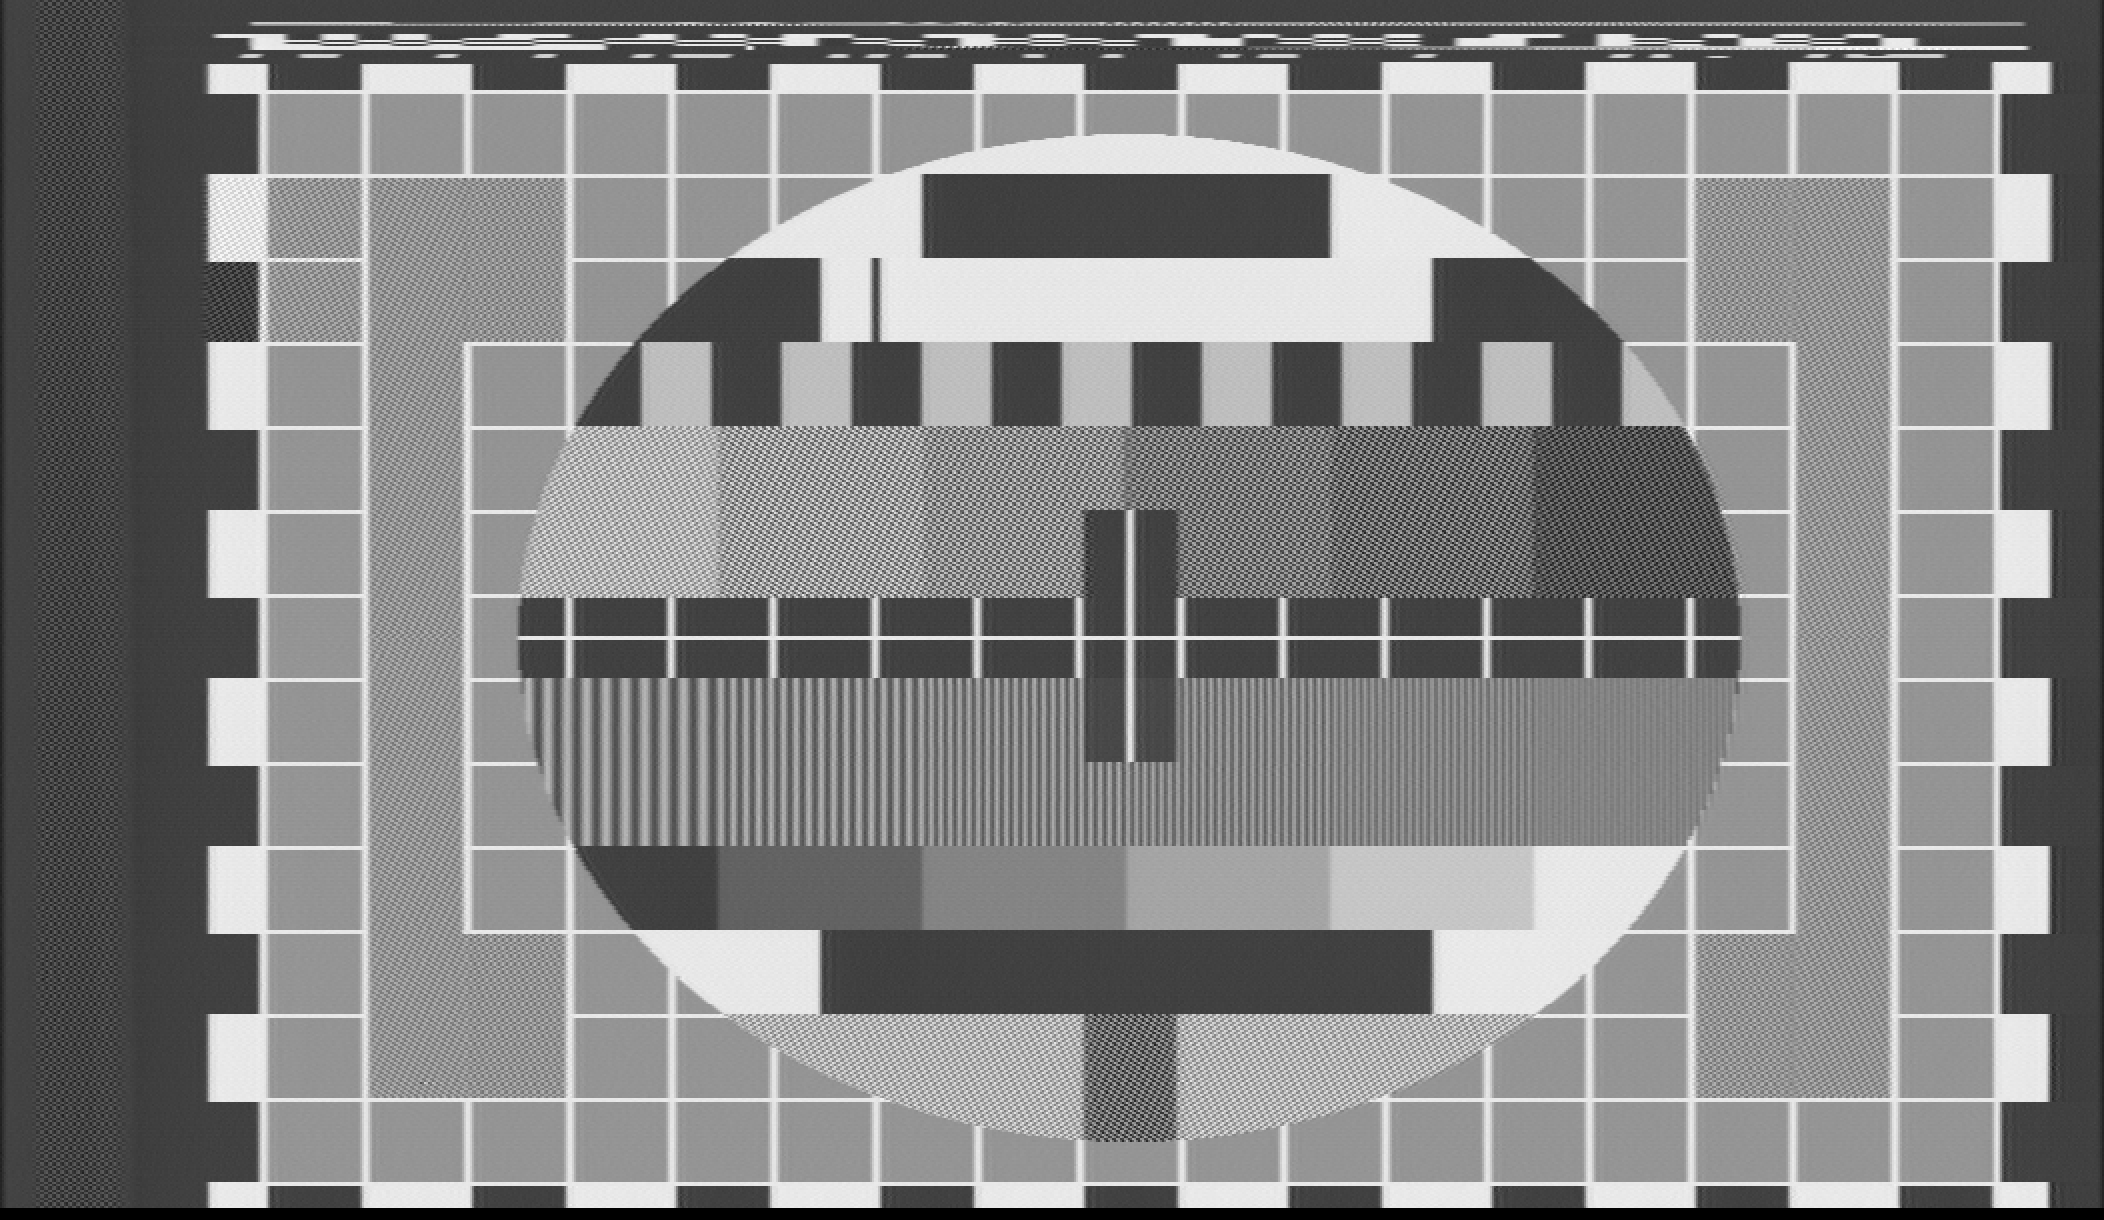

In [109]:

pictures = [x[0].downscale(lineinfo = x[0].linelocs, wow = False), x[1].downscale(lineinfo = x[1].linelocs, wow = False)]
if x[0].isfirst:
    pictures = [pictures[1], pictures[0]]

outwidth = 1052
combined = np.zeros((outwidth * 610), dtype=np.double)

for i in range(0, 604, 2):
    curline = (i // 2) + 10
    combined[((i + 0) * outwidth):((i + 1) * outwidth)] = pictures[0][curline * x[0].outlinelen: (curline * x[0].outlinelen) + outwidth]
    combined[((i + 1) * outwidth):((i + 2) * outwidth)] = pictures[1][curline * x[0].outlinelen: (curline * x[0].outlinelen) + outwidth]

reduced = (combined - rfd.SysParams['ire0']) / rfd.SysParams['hz_ire']
reduced += 40
out_scale = 65534.0 / 160
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

draw_raw_bwimage(lines16, outwidth, 610, hscale=2, vscale=2)

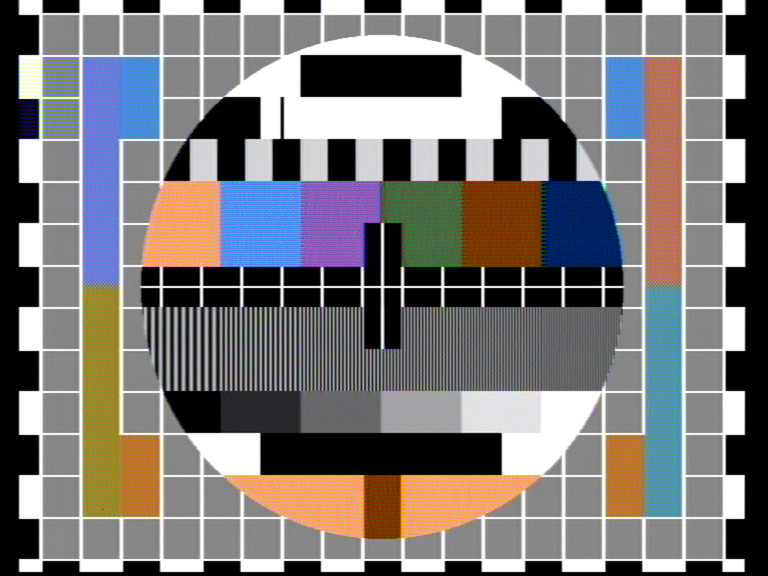

In [110]:
outfile = open('tmppal.tbc', 'wb')
outfile.write(lines16)

import os
os.system("cat tmppal.tbc | ./comb-pal -d 2 - > testx.rgb; convert -size 974x576 -depth 16 -resize 200%\! rgb:testx.rgb -resize 768x576\! testpal.png")


#from IPython.display import Image
IPython.display.Image("testpal.png")

In [75]:
625/2

312.5

In [74]:
610//2

305

In [77]:
curline

313

In [72]:
pictures[0][curline * x[0].outlinelen: (curline * x[0].outlinelen) + outwidth]

array([], dtype=float64)

In [71]:
[curline * x[0].outlinelen, (curline * x[0].outlinelen) + outwidth]

[355255, 356307]

In [65]:
curline,pictures[0][curline * x[0].outlinelen: (curline+1 * x[0].outlinelen) + outwidth]

(10, array([], dtype=float64))

In [67]:
pictures[0][curline * x[0].outlinelen]

6924622.615348288

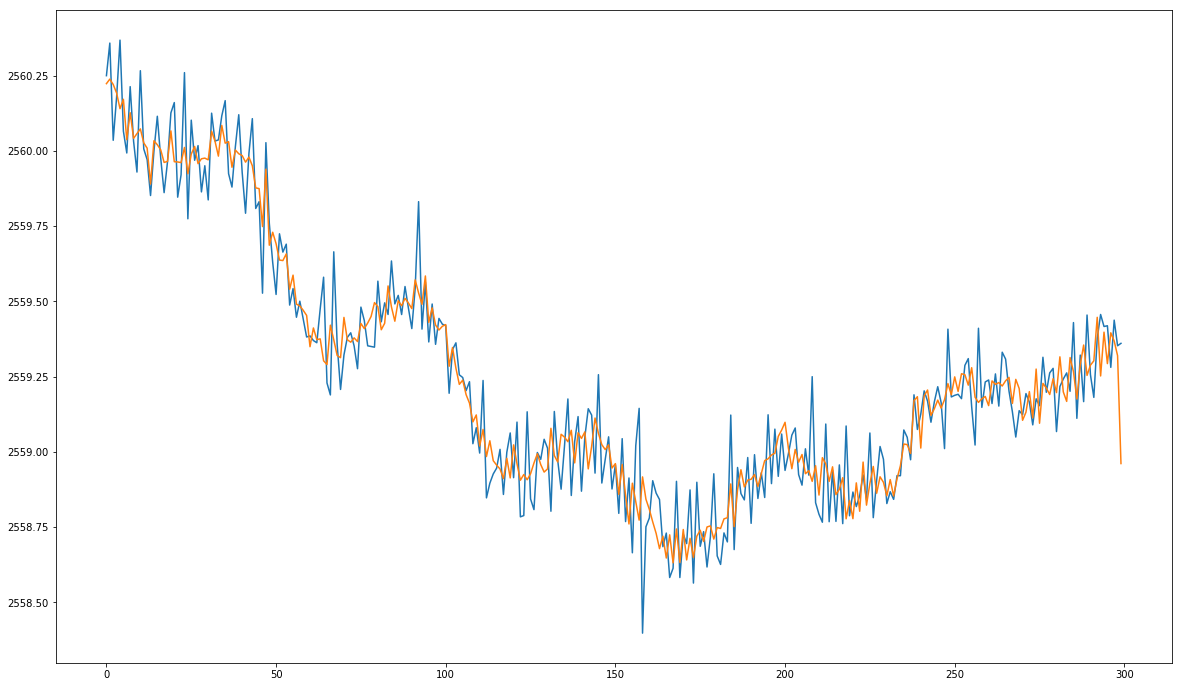

In [111]:
plt.plot(np.diff(x[0].linelocs2[12:-3]))
plt.plot(np.diff(x[0].linelocs[12:-3]))
#plt.plot(np.diff(llt0[12:-3]))
#plt.plot(np.diff(x.linelocsx[12:-3]))

In [43]:
rfd.SysParams

{'FPS': 25,
 'analog_audio': False,
 'audio_lfreq': 683593.75,
 'audio_rfreq': 1066406.25,
 'frame_lines': 625,
 'fsc_mhz': 4.43361875,
 'hz_ire': 8000.0,
 'ire0': 7100000,
 'line_period': 64,
 'outlinelen': 1135,
 'outlinelen_pilot': 960,
 'philips_codelines': [19, 20, 21],
 'pilot_mhz': 3.75}

In [66]:
np.int(np.round(4*1000000*rfd.SysParams['pilot_mhz']*(rfd.SysParams['line_period']/1000000)))

916

In [93]:
def refine_linelocs_pilot(self):
    linelocsx = self.linelocs.copy()

    plen = self.rf.SysParams['outlinelen_pilot']
    ds_pilot15 = self.downscale(outwidth=plen, channel='demod_pilot')
    ds_picture15 = self.downscale(outwidth=plen, channel='demod')

    loffsets = np.full(len(linelocsx), np.nan, dtype=np.float32)

    for l in range(1, self.linecount+1):
        pilot = ds_picture15[int((l*plen) - (4.3*15)):int((l*plen) - (.6*15))].copy()
        pilot = ds_pilot15[int((l*plen) - (3.3*15)):int((l*plen) + (.6*15))].copy()

        pilot -= np.mean(pilot)
        pilot_std = np.std(pilot)

        offsets = 0
        oc = 0
        i = 0
        while i < len(pilot):
            # use only low->high transitions since the low level is only valid in pilot signals
            if pilot[i] < -np.std(pilot):
                zc = calczc(pilot, i, 0)
                if zc:
                    i = int(np.ceil(zc))
                    offsets += zc - ((zc//4)*4)
                    oc += 1

            i += 1

        if (oc):
            offsets /= oc
            loffsets[l] = offsets
            print(l, offsets)

    tgt = np.round(np.median(loffsets[np.isnan(loffsets) == False]))
    print(tgt)
    
    # Now correct offsets that are outside the expected range
    loffsets[np.isnan(loffsets)] = 0
    loffsets[np.where((loffsets - tgt) < -2)] += 4
    loffsets[np.where((loffsets - tgt) > 2)] -= 4

    for l in range(1, self.linecount):
        if np.isnan(loffsets[l]):
            continue

        print(l, (loffsets[l] - tgt) * (self.rf.freq / 15))
        linelocsx[l] += (loffsets[l] - tgt) * (self.rf.freq / 15)
        linelocsx[l] += 1

    return linelocsx

#llt0 = refine_linelocs_pilot(x[0])
#llt1 = refine_linelocs_pilot(x[1])

def _refine_linelocs_pilot(self):
    linelocsx = self.linelocs2.copy()

    plen = self.rf.SysParams['outlinelen_pilot']
    ds_pilot15 = self.downscale(outwidth=plen, channel='demod_pilot')
    ds_picture15 = self.downscale(outwidth=plen, channel='demod_pilot')

    loffsets = np.full(len(linelocsx), np.nan, dtype=np.float32)

    for l in range(1, self.linecount+1):
        pilot = ds_picture15[int((l*plen) - (4.3*15)):int((l*plen) - (.6*15))].copy()
        #pilot = ds_pilot15[int((l*plen) - (3.3*15)):int((l*plen) + (.6*15))].copy()

        pilot -= np.mean(pilot)
        pilot_std = np.std(pilot)

        first = None
        total = 0
        oc = 0
        
        i = 0
        while i < len(pilot):
            # use only low->high transitions since the low level is only valid in pilot signals
            if pilot[i] < -np.std(pilot):
                zc = calczc(pilot, i, 0)
                
                if zc:
                    if oc == 0:
                        first = zc
                
                    x = np.round((zc - first) / 4) * 4
                    total += (zc - x)

                    print(l, i, zc, zc - x)
                    oc += 1

            i += 1

        if (oc):
            mean = total / oc
            rt = np.round(mean / 4) * 4
            loffsets[l] = rt - mean
            print(l, mean, rt, rt - mean)

    tgt = np.round(np.median(loffsets[np.isnan(loffsets) == False]))
    print(tgt)

    # Now correct offsets that are outside the expected range
    loffsets[np.isnan(loffsets)] = 0
    loffsets[np.where((loffsets - tgt) < -2)] += 4
    loffsets[np.where((loffsets - tgt) > 2)] -= 4

    for l in range(1, self.linecount):
        if np.isnan(loffsets[l]):
            continue

        print(l, (loffsets[l] - tgt) * (self.rf.freq / 15))
        linelocsx[l] += (loffsets[l] - tgt) * (self.rf.freq / 15)
        #linelocsx[l] += 1

    return linelocsx

#llt0 = _refine_linelocs_pilot(x[0])
#llt1 = _refine_linelocs_pilot(x[1])

1 0.26740930338506885
2 0.669489711597976
3 0.5993123525620977
4 0.6269466256736859
5 0.6239225353813406
6 0.6106231964837385
7 0.6468310205826036
8 0.5882818132005596
9 0.5874509844562897
10 0.6380439702865046
11 0.6248453614972811
12 0.6222642216230393
13 0.6277241972454445
14 0.619181358640481
15 0.6237753136194193
16 0.6167107415834491
17 0.6138613524255292
18 0.6132038688750964
19 0.6284528575070621
20 0.6227108523948847
21 0.6183249602367514
22 0.627813121069556
23 0.6223948689480546
24 0.6243929587078718
25 0.624618894049678
26 0.6235046441314047
27 0.62099456814199
28 0.6151197154884326
29 0.6201408401787835
30 0.618516539739549
31 0.6237212752118947
32 0.6177238251833669
33 0.6238876140760131
34 0.627962331036251
35 0.628623326285579
36 0.6063394918312904
37 0.6220968661597019
38 0.6074029913110714
39 0.6176101550820673
40 0.6127267629011651
41 0.6246719722244669
42 0.6050265935012175
43 0.6369152416000248
44 0.6258763401299645
45 0.6282584135950919
46 0.6231157197979058
47 0.

21 0.6323727116365322
22 0.6229519523786092
23 0.6233338773125154
24 0.6089088331034563
25 0.6259999208322827
26 0.6247321076451455
27 0.602541032465588
28 0.6153351928070876
29 0.6231533340500242
30 0.6233457406673698
31 0.6152984845616455
32 0.6227498220235309
33 0.6143299093273513
34 0.6239316751589201
35 0.6229352122880326
36 0.6301193074292102
37 0.6226558147169237
38 0.6218211316832002
39 0.6177540797065135
40 0.608145442811771
41 0.6316891729292412
42 0.6206370943882672
43 0.6047878820228033
44 0.6218102934288958
45 0.616514760575075
46 0.6194061908660742
47 0.6143900882767442
48 0.6152872802235039
49 0.6126305869085669
50 0.6053807313140179
51 0.5976697399635094
52 0.6120570900377263
53 0.6125381306563075
54 0.6038013190403294
55 0.607458745630693
56 0.6111943821212736
57 0.6134820757309175
58 0.6209942101512073
59 0.6092501001506299
60 0.601991908759025
61 0.6119349033148122
62 0.6040565683099459
63 0.592294608702786
64 0.5998110421792954
65 0.5893881424682109
66 0.60429764798